# 1. Trabajo Práctico N°2: de Analisis + Curación

# Trabajo Práctico N°2: Análisis Exploratorio y Curación de Datos

## Introducción

Este trabajo práctico intenta continúa la exploración de los datasets planteados en el [primer trabajo práctico](https://github.com/luisdvlpr/diplodatos2021-datasets/blob/main/TP1_Analisis_y_Visualizacion/enunciado_tp1_analisis_y_visualizacion.ipynb)

En el primer práctico pudimos notar algunas características propias de las series temporales y en particular del dominio del comportamiento de un ecommerce genérico. Muchas de ellas son __series no estacionarias__, ya que la caracterización de estas distribuciones ( media, varianza ) cambian a través del tiempo y se observan ademas alguna tendencias. __Por otra parte se se distinguen patrones de estacionalidad, por ej. semanal__. 

Lo anterior trae __consecuencias__ directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de __valores faltantes__, detección de __outliers__ y la construcción de __modelos predictivos__.

Por otra parte, debe notarse que el tamaño de las economías de cada pais y la adopción de los hábitos de uso de estas plataformas en cada uno de ellos hace que el uso de cantidad de sesiones no sea una medida adecuada para compararles. Entonces, el análisis de estas series se centra por lo general en el cambio porcentual de los precios en vez del cambio en los valores absolutos. Esto resulta en que en vez de modelar los índices originales, previamente se habitúa realizar una __transformación logarítmica__ o trabajar con la __tasa de conversión__ a fin de expresarlos en un __único métrica que les caracterice__ para evitar distorsiones debidas a los tamaños de sus economías y hábitos de uso.

# Consignas del trabajo práctico N°2

El objetivo general del práctico es realizar algunas tareas de __preprocesamiento__ de los datos y luego __analizar las series obtenidas__ de dicho preprocesamiento en forma similar a la empleada en el TP1.

Se proponen las siguientes actividades orientadoras, sin perjuicio de que se puedan incorporar análisis adicionales:

#### Tratamiento de faltantes

- Identificar valores perdidos, huecos en los datos ej: aquellos días para los que no hubo datos

- Identificar aquellos valores "sospechosos", debido al dropout ( o perdida de sesiones) a medidas que avanzas en 
  las pantallas la cantidad de sesiones en la pantalla posterior es menor/igual al de su predecesora

- Imputar los valores sospechoso con otros que tengan sentido dentro del dominio segun lo explicado en el punto anterior

- Imputar los faltantes debidos a fallas de medición usando un algoritmo adecuado para series temporales, 
  por ejemplo splines, interpolaciones, valores de medias/medianas móviles por ventana de tiempo

- Comparar los valores originales vs los imputados y juzgue si los valores se mantienen dentro de parametros aceptables, ¿Como justificaría que dichos valores imputados tienen sentido en su analisis?


#### Transformaciones

Obtener las siguientes series transformadas:

- Los logaritmos naturales de los índices. 

- Las tasas de conversion.

#### Exploración de las series transformadas

Reutilizar parte del código del TP1 para analizar las series transformadas. En una primera etapa se puede trabajar con solo una de las series resultantes de tomar logaritmo natural y una serie de tasa de conversión.

- Analizar las distribuciones por medio de gráficos y medidas de estadística descriptiva.

- Dichas distribuciones, ¿se mantienen relativamente inalteradas en el tiempo?

- ¿Hay outliers?

- Estudiar la evolución temporal de las series. ¿En qué sentido tienden a moverse? ¿Tienden a moverse en forma conjunta?  ¿Siempre se da dicho patrón? ¿Hay períodos de crisis? En caso de que existan crisis / eventos , ¿Son globales o propias de sites individuales? 

- To Be defined: De ser definido, podemos establecer un grupo de control versus ls valores imputados y establecer 
  que tan buenos resultaron los métodos ejecutados para rellenar los valores respecto de los deseables

#### Opcional
- Graficar e interpretar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
- Explorar la volatilidad de las series, por ejemplo graficando las desviaciones estándar móviles.

## Fecha de entrega

- __Versión preliminar: 03/07__ 

- __Version final: 07/07__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo puede orientarse para un público técnico pero que desconoce los aspectos propios del problema como sus compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se explique un análisis escrito suficientemente detallado de los resultados. 


### ***1- CARGA DEL DATASET***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# some config

plt.rcParams['figure.figsize'] = (12, 9)
pd.options.display.float_format = '{:20,.2f}'.format #configuración para sacar la notación cientifica

In [3]:
data_orig = pd.read_csv(
    'https://raw.githubusercontent.com/luisepifanio/diplodatos2021-datasets/main/TP2_Analisis_y_Curacion/datasets/traffic_AR_CL_UY.csv', 
    usecols = ["Fecha", "flow", "Site", "Device", "Loading", "Shipping", "Payments", "Review", "Congrats"], 
    parse_dates=["Fecha"],index_col=["Fecha"])
traffic_data=data_orig.copy()

In [4]:
#filtramos los datos para trabajar solo con MLA, flujo directo, desktop y android

traffic_data = traffic_data[traffic_data.Site==("MLA")]
traffic_data = traffic_data[traffic_data.flow==("direct")]
traffic_data = traffic_data[(traffic_data.Device==("Android"))|(traffic_data.Device==("Desktop"))]

#agrupamos las columnas que sean etapas de compra de interés. 
cols_etapas = ['Shipping', 'Payments', 'Review', 'Congrats']

### ***2- DATOS FALTANTES***

En un primer momento se identifica si el dataset incluye valores "Not a number". Esto puede haber sucedido por una falla en la medición, o por algún problema en el procesamiento de los mismos.

In [5]:
#Datos faltantes según el tipo de DEVICE
traffic_data.drop('Device', 1).isna().groupby(traffic_data.Device, sort=False).sum()

,flow,Site,Loading,Shipping,Payments,Review,Congrats
Device,,,,,,,
Android,0,0,0,1,0,2,0
Desktop,0,0,0,0,0,0,0


Solo tres datos aparecen como faltantes en el dataset, dos de ellos en la etapa de review y uno en la etapa de shipping. Los tres pertenecen al device ANDROID. En DESKTOP no se presentan datos faltantes.

In [6]:
#localizamos los datos faltantes en el dataset original
traffic_data[traffic_data['Shipping'].isnull()|traffic_data['Review'].isnull()]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats
Fecha,,,,,,,,
2019-03-22,direct,MLA,Android,179146,"169,846.00",138177,nan,89890
2019-05-07,direct,MLA,Android,224056,nan,172472,"121,321.00",113250
2019-08-27,direct,MLA,Android,236701,"223,993.00",180928,nan,113464


Podemos identificar que los 3 datos faltantes corresponden a los devices Android sin estar correlacionados entre sí, con fechas diferentes en cada caso: 22 de Marzo, 7 de Mayo y 27 de Agosto de 2019.

### ***3- DATOS NULOS***

Otro caso que puede surgir es que los valores del dataset no sean missing values, sino datos nulos, es decir, observaciones igualadas a cero. En este caso, y si no surge del conocimiento de dominio que esto sea correcto por algún hecho puntual, estos ceros deben ser identificados y luego imputados con valores acorde al dominio.

In [7]:
#buscamos los datos nulos e identificamos en qué columnas se encuentran..
cols_null = traffic_data[traffic_data == 0].count(axis=0)
cols_null[cols_null > 0]

Loading     4
Shipping    4
Payments    4
Review      4
Congrats    4
dtype: int64

In [8]:
#buscamos en el data set el conjunto de datos correspondientes a los casos donde se encuentran los valores nulos
columns = traffic_data.columns.tolist()
columns
traffic_data_null = traffic_data[(traffic_data.iloc[:,:] == 0).any(axis=1)]
traffic_data_null

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats
Fecha,,,,,,,,
2019-12-05,direct,MLA,Android,0,0.00,0,0.00,0
2019-12-05,direct,MLA,Desktop,0,0.00,0,0.00,0
2019-12-06,direct,MLA,Android,0,0.00,0,0.00,0
2019-12-06,direct,MLA,Desktop,0,0.00,0,0.00,0


Podemos afirmar que solo hay dos fechas con valores iguales a 0. Ambos se corresponden a los mismos días tanto para Android como para Desktop: 5 y 6 de Diciembre de 2019. Dos días consecutivos.
En ambos casos, todas las etapas son 0, por ello los convertiremos en Nan y luego los imputaremos.

In [9]:
#Reemplazamos los valos nulos por nan
traffic_data = traffic_data.replace(['0', 0], np.nan)

In [10]:
#verificamos
traffic_data['2019-12-05':'2019-12-06']

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats
Fecha,,,,,,,,
2019-12-05,direct,MLA,Android,nan,nan,nan,nan,nan
2019-12-05,direct,MLA,Desktop,nan,nan,nan,nan,nan
2019-12-06,direct,MLA,Android,nan,nan,nan,nan,nan
2019-12-06,direct,MLA,Desktop,nan,nan,nan,nan,nan


####  ***4- VALORES PERDIDOS***

Otra instancia en la limpieza y el preprocesamiento de datos cuando se trabaja con series de tiempo implica identificar si la serie saltea una o más fechas. 

In [11]:
traffic_data_android = traffic_data[traffic_data.Device==("Android")]
traffic_data_desktop = traffic_data[traffic_data.Device==("Desktop")]

traffic_data_len = traffic_data.index.nunique()
print("El periodo de tiempo analizado es de",  traffic_data_len , "días.")

traffic_data_len_android = len(traffic_data_android.index)
traffic_data_len_desktop = len(traffic_data_android.index)

print("En Android tenemos:", traffic_data_len_android,"y en Desktop:", traffic_data_len_desktop, "por lo que concluímos que los datasets de ambos devices estan completos")

El periodo de tiempo analizado es de 488 días.
En Android tenemos: 488 y en Desktop: 488 por lo que concluímos que los datasets de ambos devices estan completos


### ***5- DATOS SOSPECHOSOS***

Habiendo ya identificado los valores problemáticos más evidentes, analizaremos las series de datos para identificar valores sospechosos, ya con conocimiento de dominio.
En primer lugar se verá si existen fechas en las cuales la lógica de funnel no se cumple, es decir, que en una etapa posterior del proceso de compra se cuenta con más transacciones que en una etapa anterior. Para ello se calculan las tasas de conversión entre las etapas y se verifica si hay alguna superior a uno.

In [12]:
#agregamos columnas relativas a las tasas de conversión entre las diferentes etapas de compra

#no agregaría las columnas de los índices hasta no imputar los valores NaN, así tenemos menos datos que imputar

df_traffic=traffic_data.copy()
df_traffic["Shipping-Payments"] = df_traffic["Payments"] / df_traffic["Shipping"]
df_traffic["Payments-Review"] = df_traffic["Review"] / df_traffic["Payments"]
df_traffic["Review-Congrats"] = df_traffic["Congrats"] / df_traffic["Review"]
df_traffic["Shipping-Congrats"] = df_traffic["Congrats"] / df_traffic["Shipping"]

#agrupamos las columnas de índices para evaluar su comportamiento por separado de las etapas
cols_indices = ['Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats']

#agregamos columnas relativas a las fechas ya que nos interesa el comportamiento temporal
df_traffic["Weekday"] = df_traffic.index.day_name()
df_traffic["Month"] = df_traffic.index.month_name()
df_traffic["Year"] = df_traffic.index.year
new = df_traffic["Month"].copy().astype(str)
new1 = df_traffic["Year"].copy().astype(str)
df_traffic["Months"]= new.str.cat(new1, sep ="-")

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

In [13]:
#Buscamos en el dataset observaciones que no cumplan con la lógica del funnel, que presenten en una etapa previa menos
#observaciones que en una posterior
columns = df_traffic.columns.tolist()
columns
df_traffic_sospechoso = df_traffic[(df_traffic[cols_indices].iloc[:,:] > 1).any(axis=1)]
df_traffic_sospechoso

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,


Como se puede observar en la última celda, no se identificaron casos en los cuales una tasa de conversión fuera superior a uno. Es por ello que procederemos a analizar si existen outliers en el dataset que deban ser tratados.

In [14]:
df_traffic.describe()

,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Year
count,972.00,971.00,972.00,970.00,972.00,971.00,970.00,970.00,971.00,976.00
mean,"192,955.77","181,541.90","148,428.32","103,622.26","97,196.05",0.82,0.71,0.95,0.56,"2,019.37"
std,"109,318.01","102,431.53","82,304.53","54,368.80","49,451.14",0.04,0.06,0.03,0.08,0.48
min,"30,819.00","28,722.00","3,823.00","2,597.00","2,538.00",0.03,0.50,0.86,0.02,"2,019.00"
25%,"121,197.25","114,433.00","96,055.25","71,472.25","68,528.50",0.81,0.67,0.92,0.49,"2,019.00"
50%,"171,517.00","162,331.00","130,287.50","90,169.50","85,017.00",0.82,0.71,0.94,0.55,"2,019.00"
75%,"247,064.25","234,561.00","189,188.00","133,115.75","124,910.25",0.85,0.77,0.97,0.63,"2,020.00"
max,"563,592.00","537,723.00","444,330.00","286,162.00","264,742.00",0.88,0.81,1.00,0.68,"2,020.00"


Llaman la atención los valores mínimos de las etapas Payments, Review y Congrats, ya que son sustancialmente superior a los valores normales para estas transacciones. A continuación ubicamos los mismos temporalmente.

In [15]:
df_traffic[(df_traffic['Payments']<4000)|(df_traffic['Review']<2600)|(df_traffic['Congrats']<2600)]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,
2019-12-04,direct,MLA,Desktop,"146,932.00","138,124.00","3,823.00","2,597.00","2,538.00",0.03,0.68,0.98,0.02,Wednesday,December,2019,December-2019


Todos estos valores atípicos se dieron el 4 de ciciembre de 2019, un día antes de que el dataset presentara datos nulos en todas sus etapas durante dos días. En el siguiente boxplot puede verse que los mismos son outliers y, por consiguiente, se procederá a reemplazarlos por valores nulos para su posterior imputación.

Text(0.5, 1.0, 'Etapas')

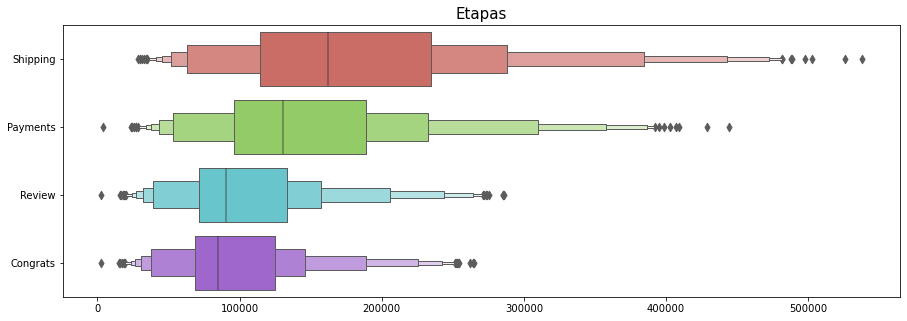

In [16]:
#Analizamos con un boxenplot si se trata de outliers
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxenplot(data=df_traffic[cols_etapas], orient = "h", palette='hls')
plt.title('Etapas', size=15)

In [17]:
#Reemplazamos los valores minimos por NaNs
df_traffic = df_traffic.replace([3823, 2597, 2538], np.nan)

### ***6- IMPUTACIÓN DE VALORES FALTANTES/NULOS/ATÍPICOS**

Para poder trabajar con las series, se procederá a imputar tanto los datos faltantes como los nulos. Para ello, se trabajará con la mediana de las dos semanas anteriores a la semana en la que se dan los valores faltantes y nulos. 

In [18]:
df_traffic.isnull().groupby(df_traffic.Device).sum()

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Device,,,,,,,,,,,,,,,,
Android,0,0,0,2,3,2,4,2,3,4,4,3,0,0,0,0
Desktop,0,0,0,2,2,3,3,3,2,2,2,2,0,0,0,0


#### ***Imputación en Android***

In [19]:
#todo lo que hay que imputar
df_traffic_android[df_traffic_android['Review'].isnull()]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,"179,146.00","169,846.00","138,177.00",nan,"89,890.00",0.81,nan,nan,0.53,Friday,March,2019,March-2019
2019-08-27,direct,MLA,Android,"236,701.00","223,993.00","180,928.00",nan,"113,464.00",0.81,nan,nan,0.51,Tuesday,August,2019,August-2019
2019-12-05,direct,MLA,Android,nan,nan,nan,nan,nan,nan,nan,nan,nan,Thursday,December,2019,December-2019
2019-12-06,direct,MLA,Android,nan,nan,nan,nan,nan,nan,nan,nan,nan,Friday,December,2019,December-2019


In [20]:
#mediana de las semanas de marzo que necesitamos
df_traffic_android['2019-03-14':'2019-03-21'].median()

Loading                       187,450.50
Shipping                      177,984.50
Payments                      144,332.00
Review                         99,426.00
Congrats                       93,201.00
Shipping-Payments                   0.81
Payments-Review                     0.69
Review-Congrats                     0.94
Shipping-Congrats                   0.52
Year                            2,019.00
dtype: float64

In [21]:
df_traffic.loc['2019-03-22', 'Review'].replace(np.nan, 138177*0.69, inplace=True)

C:\Users\macuc\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [22]:
df_traffic['2019-03-22':'2019-03-22']

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,"179,146.00","169,846.00","138,177.00","95,342.13","89,890.00",0.81,nan,nan,0.53,Friday,March,2019,March-2019
2019-03-22,direct,MLA,Desktop,"112,147.00","106,408.00","91,762.00","72,190.00","70,180.00",0.86,0.79,0.97,0.66,Friday,March,2019,March-2019


In [23]:
#mediana de las semanas de agosto que necesitamos
df_traffic_android['2019-08-19':'2019-08-26'].median()

Loading                       222,054.00
Shipping                      209,607.50
Payments                      167,252.00
Review                        110,225.50
Congrats                      101,450.50
Shipping-Payments                   0.80
Payments-Review                     0.65
Review-Congrats                     0.92
Shipping-Congrats                   0.48
Year                            2,019.00
dtype: float64

In [24]:
df_traffic.loc['2019-08-27', 'Review'].replace(np.nan, 180928*0.65, inplace=True)

C:\Users\macuc\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [25]:
df_traffic['2019-08-27':'2019-08-27']

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,
2019-08-27,direct,MLA,Android,"236,701.00","223,993.00","180,928.00","117,603.20","113,464.00",0.81,nan,nan,0.51,Tuesday,August,2019,August-2019
2019-08-27,direct,MLA,Desktop,"124,108.00","118,209.00","102,472.00","76,035.00","74,640.00",0.87,0.74,0.98,0.63,Tuesday,August,2019,August-2019


In [26]:
df_traffic[df_traffic['Review'].isnull()]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Weekday,Month,Year,Months
Fecha,,,,,,,,,,,,,,,,
2019-12-04,direct,MLA,Desktop,"146,932.00","138,124.00",nan,nan,nan,0.03,0.68,0.98,0.02,Wednesday,December,2019,December-2019
2019-12-05,direct,MLA,Android,nan,nan,nan,nan,nan,nan,nan,nan,nan,Thursday,December,2019,December-2019
2019-12-05,direct,MLA,Desktop,nan,nan,nan,nan,nan,nan,nan,nan,nan,Thursday,December,2019,December-2019
2019-12-06,direct,MLA,Android,nan,nan,nan,nan,nan,nan,nan,nan,nan,Friday,December,2019,December-2019
2019-12-06,direct,MLA,Desktop,nan,nan,nan,nan,nan,nan,nan,nan,nan,Friday,December,2019,December-2019


In [27]:
#mediana de las semanas de agosto que necesitamos
df_traffic_desktop['2019-11-27':'2019-12-03'].median()

Loading                       119,935.00
Shipping                      112,811.00
Payments                       95,304.00
Review                         73,870.00
Congrats                       72,023.00
Shipping-Payments                   0.84
Payments-Review                     0.76
Review-Congrats                     0.97
Shipping-Congrats                   0.63
Year                            2,019.00
dtype: float64

In [28]:
df_traffic.loc['2019-12-04', 'Payments'].replace(np.nan, 138124*0.84, inplace=True)
df_traffic.loc['2019-12-04', 'Review'].replace(np.nan, 138124*0.84*0.76, inplace=True)
df_traffic.loc['2019-12-04', 'Congrats'].replace(np.nan, 138124*0.84*0.76*0.97, inplace=True)

C:\Users\macuc\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [29]:
df_traffic_desktop.loc['2019-11-01':'2019-12-03'].groupby('Weekday').median()

,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Year
Weekday,,,,,,,,,,
Friday,"108,648.00","101,930.00","86,767.00","67,833.00","66,191.00",0.85,0.78,0.98,0.65,2019
Monday,"150,301.00","141,573.00","121,093.00","94,276.00","91,933.00",0.85,0.78,0.97,0.64,2019
Saturday,"52,243.00","48,816.00","40,903.00","30,022.00","29,232.00",0.84,0.72,0.97,0.59,2019
Sunday,"48,978.00","45,426.00","37,222.00","27,217.00","26,724.00",0.83,0.73,0.97,0.59,2019
Thursday,"117,014.00","110,404.50","93,722.00","72,371.50","69,970.00",0.85,0.77,0.97,0.62,2019
Tuesday,"133,687.00","125,652.00","107,123.00","83,293.00","80,926.00",0.85,0.78,0.97,0.64,2019
Wednesday,"122,951.00","115,670.50","98,365.00","76,553.00","74,750.00",0.85,0.78,0.98,0.64,2019


In [30]:
df_traffic_desktop.loc['2019-11'].groupby('Weekday').median()

,Loading,Shipping,Payments,Review,Congrats,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats,Year
Weekday,,,,,,,,,,
Friday,"108,648.00","101,930.00","86,767.00","67,833.00","66,191.00",0.85,0.78,0.98,0.65,2019
Monday,"142,881.50","134,420.00","114,557.00","89,195.50","86,908.00",0.85,0.76,0.97,0.63,2019
Saturday,"52,243.00","48,816.00","40,903.00","30,022.00","29,232.00",0.84,0.72,0.97,0.59,2019
Sunday,"48,447.00","45,136.50","37,175.00","26,817.50","26,190.50",0.83,0.72,0.97,0.58,2019
Thursday,"117,014.00","110,404.50","93,722.00","72,371.50","69,970.00",0.85,0.77,0.97,0.62,2019
Tuesday,"131,130.50","123,591.00","105,820.50","82,435.00","79,836.00",0.86,0.77,0.97,0.64,2019
Wednesday,"122,951.00","115,670.50","98,365.00","76,553.00","74,750.00",0.85,0.78,0.98,0.64,2019


In [32]:
df_traffic[df_traffic.Device=="Desktop"].loc['2019-12-05', 'Loading'].replace(np.nan, 117014.00, inplace=True)
df_traffic[df_traffic.Device=="Desktop"].loc['2019-12-05', 'Shipping'].replace(np.nan, 110404.50, inplace=True)
df_traffic[df_traffic.Device=="Desktop"].loc['2019-12-05', 'Payments'].replace(np.nan, 93722.00, inplace=True)
df_traffic[df_traffic.Device=="Desktop"].loc['2019-12-05', 'Review'].replace(np.nan, 73371.50, inplace=True)
df_traffic[df_traffic.Device=="Desktop"].loc['2019-12-05', 'Congrats'].replace(np.nan, 69970.00, inplace=True)

AttributeError: 'numpy.float64' object has no attribute 'replace'

In [ ]:
# explicar porque este método

In [ ]:
df_traf_int = df_traf.interpolate()

In [ ]:
#generamos una copia para volver a agregarle las columnas de interes 
df_traffic2=df_traf_int.copy()

#columnas de índices
df_traffic2["Shipping-Payments"] = df_traffic2["Payments"] / df_traffic2["Shipping"]
df_traffic2["Payments-Review"] = df_traffic2["Review"] / df_traffic2["Payments"]
df_traffic2["Review-Congrats"] = df_traffic2["Congrats"] / df_traffic2["Review"]
df_traffic2["Shipping-Congrats"] = df_traffic2["Congrats"] / df_traffic2["Shipping"]

#columnas relativas a las fechas
df_traffic2["Weekday"] = df_traf_int.index.day_name()
df_traffic2["Month"] = df_traf_int.index.month_name()
df_traffic2["Year"] = df_traf_int.index.year
new = df_traffic2["Month"].copy().astype(str)
new1 = df_traffic2["Year"].copy().astype(str)
df_traffic2["Months"]= new.str.cat(new1, sep ="-")

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic2_desktop = df_traffic2[df_traffic2.Device==("Desktop")]
df_traffic2_android = df_traffic2[df_traffic2.Device==("Android")]

In [ ]:
#Lo primero a verificar imputando los valores, es no romper la lógica del drop-out manteniendo los indices de conversión menores a 1
df_traffic2[cols_indices].describe()

Pudimos observar que los mètodos: lineal por defecto, cñubico, polinomial de 3 orden, spline de 2 orden, pchip, akima,  no fueron útiles dado que ciertos índices tienen valores mayores a uno. Todo lo de abajo no tiene sentido seguir desarrollando hasta no encontrar un método de interpolación que no nos rompa todo.


In [ ]:
#Observamos el dataframe en la primera semana de 
df_traffic2['2019-12-05':'2019-12-06']

In [ ]:
#Observamos el dataframe en la primera semana de 
df_traffic2['2019-12-05':'2019-12-06']

In [ ]:
#volvemos a analizamos el comportamiento en dicho mes según el día de la semana
df_traffic2_desktop['2019-12'].groupby('Weekday')[cols_indices].std()

Los días imputadis corresponden a Jueves y Viernes donde podemos notar un claro aumento de la desviación estandar.

In [ ]:
df_traffic_android['2019-03':'2019-08'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all",figsize=(20, 10)).set_title("ANDROID-Etapas")
df_traffic_android['2019-03':'2019-08'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Indices")

In [ ]:
df_traffic2_android['2019-12'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Etapas")
df_traffic2_android['2019-12'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Indices")

Tanto la interpolación cúbica como la polinomial de 3er orden fueron descartadas dado que los valores imputados no eran lógicos. 

In [ ]:
cols_indices_log=['Shipping-Payments(log)',
 'Payments-Review(log)',
 'Review-Congrats(log)',
 'Shipping-Congrats(log)']
cols_indices_log

In [ ]:
df_traffic[cols_indices_log] = np.log(df_traffic[cols_indices])

In [ ]:
df_traffic_int[cols_indices_log] = np.log(df_traffic_int[cols_indices])

In [ ]:
df_traffic_int.head()

In [ ]:
# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_int_desktop = df_traffic_int[df_traffic_int.Device==("Desktop")]
df_traffic_int_android = df_traffic_int[df_traffic_int.Device==("Android")]

In [ ]:
df_traffic[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("ANDROID - indices log")
df_traffic_int[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("ANDROID interpolada indices log")

In [ ]:
df_traffic[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("DESKTOP - indices log")
df_traffic_int[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("DESKTOP interpolada indices log")

In [ ]:
df_traffic[cols_indices_log].describe()

In [ ]:
df_traffic_int[cols_indices_log].describe()